In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import hinge_loss
from AEspeech import AEspeech
import pdb
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import joblib

In [2]:
PATH=os.getcwd()

mod="CAE"
rep='wvlt'

trainResOG_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'TrainResultsOG.pkl'
trainRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'TrainResults.pkl'
testRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'TestResults.pkl'
trainResOG=pd.read_pickle(trainResOG_path)
trainRes=pd.read_pickle(trainRes_path)
testRes=pd.read_pickle(testRes_path)

results=pd.DataFrame({utter:{'test_loss':0, 'test_acc':0, 'tstSpk_data':{}} for utter in testRes.columns})
div=max(testRes.index)[0]+1

for item in testRes:
    for index in testRes.index:
        if index[1] == 'tstSpk_data':
            results[item][index[1]].update(testRes[item][index])
        else:
            results[item][index[1]]+=testRes[item][index]/div


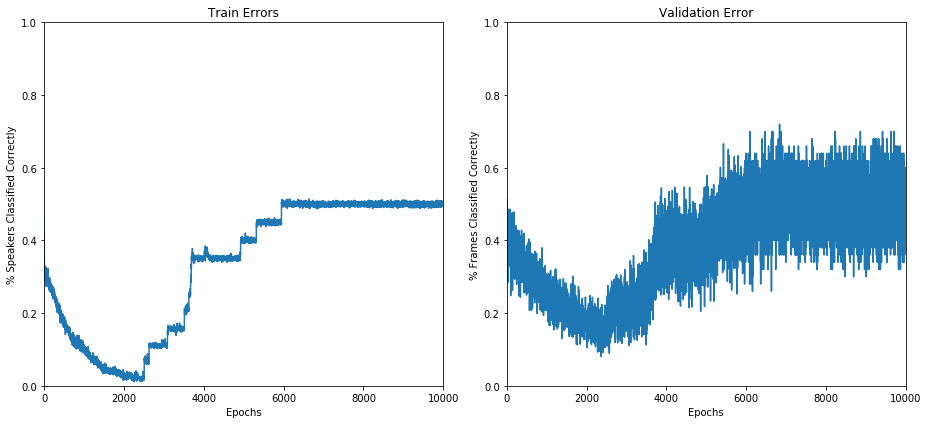

In [3]:
train_acc=0
val_acc=0
for i in range(10):
    train_acc+=trainResOG['train_acc'][i][0]/10
    val_acc+=trainResOG['val_acc'][i][0]/10
    
fig,ax=plt.subplots(1,2,figsize=(13, 6))

ax[0].plot(1-train_acc)
ax[0].set_title("Train Errors")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("% Speakers Classified Correctly")
ax[0].set_xlim([0,10000])
ax[0].set_ylim([0,1])

ax[1].plot(1-val_acc)
ax[1].set_title("Validation Error")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("% Frames Classified Correctly")
ax[1].set_xlim([0,10000])
ax[1].set_ylim([0,1])

plt.tight_layout()

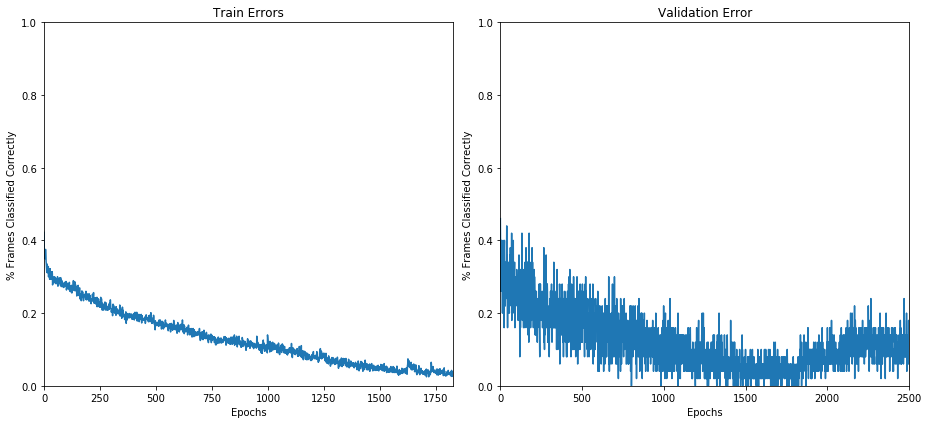

In [17]:
train_acc=0
val_acc=0
for i in range(10):
    train_acc+=trainRes['train_acc'][i][0]/10
    val_acc+=trainRes['val_acc'][i][0]/10
    
fig,ax=plt.subplots(1,2,figsize=(13, 6))

ax[0].plot(1-train_acc)
ax[0].set_title("Train Errors")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("% Frames Classified Correctly")
ax[0].set_xlim([0,1825])
ax[0].set_ylim([0,1])

ax[1].plot(1-val_acc)
ax[1].set_title("Validation Error")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("% Frames Classified Correctly")
ax[1].set_xlim([0,2500])
ax[1].set_ylim([0,1])

plt.tight_layout()

In [33]:
"""
Plotting the ROC and calculating the AUC for all binary classification scores output by the DNN for each speech frame.
"""

y_score=np.zeros((200,2))
y_test=np.zeros((200,2))
itr=0
for item in results:
    for index in testRes.index:
        if index[1] == 'tstSpk_data':
            for arr in testRes[item][index].values():                
                y_score[itr:itr+2,:]=arr
                if np.mod(itr/2,10)<5:
                    y_test[itr:itr+2,:]=np.vstack((np.ones(2),np.zeros(2))).T
                if np.mod(itr/2,10)>=5:
                    y_test[itr:itr+2,:]=np.vstack((np.zeros(2),np.ones(2))).T
                itr+=2

                

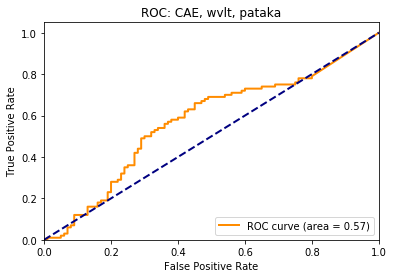

In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()
utter='pataka'
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure()
lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: '+mod+", "+rep+", "+utter)
plt.legend(loc="lower right")
plt.show()

In [122]:
"""
Plotting the ROC and AUC, but now taking the average difference of output probabilities for a given speaker 
(averaged over all frames).
"""
y_score=np.zeros(100)
y_test=np.zeros(100)

for item in results:
    for itr,arr in enumerate(results[item]['tstSpk_data'].values()):                
        y_score[itr]=np.mean(arr[:,0]-arr[:,1])
        if np.mod(itr,10)<5:
            y_test[itr]=1
        if np.mod(itr,10)>=5:
            y_test[itr]=0
        itr+=2

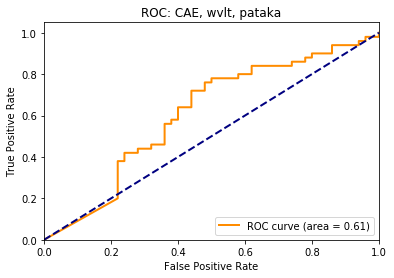

In [123]:
fpr = dict()
tpr = dict()
roc_auc = dict()
utter='pataka'
for i in range(2):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
plt.figure()
lw = 2
mgc=1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: '+mod+", "+rep+", "+utter)
plt.legend(loc="lower right")
plt.show()

In [ ]:
# y_test=[round(i*.01) for i in list(results.loc['tstSpk_data']['pataka'].keys())]
# y_score=[round((j+1)*.5) for j in list(results.loc['tstSpk_data']['pataka'].values())]
# y_test=np.ones(100)
# y_score=np.zeros(100)
# it=0
# for item in testRes:
#     for index in testRes.index:
#         if index[1] == 'test_acc':
#             curr_numC=int(float(testRes[item][index])*10)
#             y_score[it*10:it*10+curr_numC]+=1
#             it+=1

# fpr, tpr, _=roc_curve(y_test,y_score)
# roc_auc=auc(fpr, tpr)

In [ ]:
# roc_dic={thrsh*.01:{'tp':0,'fp':0,'tn':0,'fn':0} for thrsh in np.arange(101)}
# tprs=[]
# fprs=[]
# utter='pataka'

# for itr,(index, col) in enumerate(results.items()):
#     if col.name==utter:
#         tprs=[]
#         fprs=[]
# #         ax=axs[itr]
#         for thresh in roc_dic.items():
#             thr=thresh[0]
#     #         if col.name==utter:
#     #             for epoch in range(n_epochs):
#             for key,value in enumerate(list(results[index]['tstSpk_data'].values())):
#                 if value == {}:
#                     value=0
#                 if key<50 and (value+1)*.5>thr:
#                     roc_dic[thr]['tp']+=1
#                 if key<50 and (value+1)*.5<thr:
#                     roc_dic[thr]['fn']+=1
#                 if key>=50 and (value+1)*.5>thr:
#                     roc_dic[thr]['fp']+=1
#                 if key>=50 and (value+1)*.5<thr:
#                     roc_dic[thr]['tn']+=1

#             tprs.append(roc_dic[thr]['tp']/(roc_dic[thr]['tp']+roc_dic[thr]['fn']+10e-6))
#             fprs.append(roc_dic[thr]['fp']/(roc_dic[thr]['fp']+roc_dic[thr]['tn']+10e-6))


# tprs=np.sort(tprs)
# fprs=np.sort(fprs)
# fig,ax=plt.subplots(1,1,figsize=(8, 6))
# plt.plot(np.sort(fprs),np.sort(tprs))
# plt.title("PD v. HC ROC: "+mod+", "+rep+", "+utter+"\n AUC: "+str(np.round(metrics.auc(fprs, tprs),3)))
# ax.set_xlabel("FPR")
# ax.set_ylabel("TPR")
# ax.set_xlim([-.05,1.05])
# ax.set_ylim([0,1])

In [ ]:
# roc_dic={thrsh*.01:{'tp':0,'fp':0,'tn':0,'fn':0} for thrsh in np.arange(101)}
# tprs=[]
# fprs=[]
# fig,axs=plt.subplots(2,3,figsize=(12, 8))
# axs = axs.ravel()
# utter='petaka'

# for itr,(index, col) in enumerate(results.items()):
#     if col.name==utter:
#         tprs=[]
#         fprs=[]
#         ax=axs[itr]
#         for thresh in roc_dic.items():
#             thr=thresh[0]
#     #         if col.name==utter:
#     #             for epoch in range(n_epochs):
#             for key,value in enumerate(list(results[index]['tstSpk_data'].values())):
#                 if value == {}:
#                     value=0
#                 if key<50 and value>thr:
#                     roc_dic[thr]['tp']+=1
#                 if key<50 and value<thr:
#                     roc_dic[thr]['fn']+=1
#                 if key>=50 and value>thr:
#                     roc_dic[thr]['fp']+=1
#                 if key>=50 and value<thr:
#                     roc_dic[thr]['tn']+=1

#             tprs.append(roc_dic[thr]['tp']/(roc_dic[thr]['tp']+roc_dic[thr]['fn']+10e-6))
#             fprs.append(roc_dic[thr]['fp']/(roc_dic[thr]['fp']+roc_dic[thr]['tn']+10e-6))

#         ax.plot(np.sort(fprs),np.sort(tprs))
#         ax.set_title("PD v. HC ROC: "+mod+", "+rep+", "+index+"\n AUC: "+str(np.round(metrics.auc(fprs, tprs),3)))
#         ax.set_xlabel("FPR")
#         ax.set_ylabel("TPR")
#         ax.set_xlim([-.05,1.05])
#         ax.set_ylim([0,1])
#         plt.tight_layout()
    

In [ ]:
print('MEAN % of FRAMES CLASSIFIED PD')
for key,item in results.items():
    print(key+' - ', 'pd: '+str(np.round(np.mean([itm for k,itm in item['tstSpk_data'].items() if k<50]),3)), 'hc: '+str(np.round(np.mean([itm for k,itm in item['tstSpk_data'].items() if k>=50]),3)))


In [ ]:
# for key,item in results.items():
#     print(key,item['test_acc'])

In [ ]:
# n_epochs=results.iloc[-1].name[0]
# utters=['pataka','kakaka','pakata','papapa','petaka','tatata']

# col_res={ut:{key:0 for key in results.loc[0].index} for ut in utters}

# for index, col in results.items():
#     col_res[col.name]['tstSpk_data']={num:0 for num in np.arange(100)}
#     col_res[col.name]['test_accPerSpk']=0

#     for epoch in range(n_epochs):
#         col_res[col.name]['train_loss']+=col.loc[epoch]['train_loss']*(1/n_epochs)
#         col_res[col.name]['test_loss']+=col.loc[epoch]['test_loss']*(1/n_epochs)
#         col_res[col.name]['train_acc']+=col.loc[epoch]['train_acc']*(1/n_epochs)
#         col_res[col.name]['test_acc']+=col.loc[epoch]['test_acc']*(1/n_epochs)

#         for key,value in col.loc[epoch]['tstSpk_data'].items():   
# #             if value>=.5:
# #                 col_res[col.name]['test_accPerSpk']+=(1/(100*n_epochs))       
#             col_res[col.name]['tstSpk_data'][key]+=value*(1/n_epochs)
    